## import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# GPU setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080


## load data

In [3]:
xy = pd.read_csv('../data/df.csv')
xy

,일시,평균기온(°C),합계 일사량(MJ/m2),평균 지면온도(°C),평균 30cm 지중온도(°C),5.0m 지중온도(°C),일 미세먼지 농도(㎍/㎥),승차,검색량,당일 1차접종자 수,...,2차접종 누계,2차접종률(%),당일 3차접종자 수,3차접종 누계,3차접종률(%),mx,my,dx,dy,추가 확진
0,20200205,-8.3,14.82,-2.5,3.0,15.6,28.0,6855972,3.76198,0.0,...,0.0,0.0,0,0.0,0.0,8.660254e-01,0.5,0.883512,0.468408,3
1,20200206,-6.4,13.97,-2.7,2.3,15.5,46.0,6774345,4.73247,0.0,...,0.0,0.0,0,0.0,0.0,8.660254e-01,0.5,0.963550,0.267528,0
2,20200207,-1.7,10.14,-0.4,1.9,15.5,44.0,7188696,4.26499,0.0,...,0.0,0.0,0,0.0,0.0,8.660254e-01,0.5,0.998533,0.054139,0
3,20200208,-0.1,13.89,1.4,1.9,15.4,50.0,4677705,3.40660,0.0,...,0.0,0.0,0,0.0,0.0,8.660254e-01,0.5,0.986827,-0.161782,0
4,20200209,-0.5,14.33,0.5,2.2,15.4,42.0,3442364,3.06098,0.0,...,0.0,0.0,0,0.0,0.0,8.660254e-01,0.5,0.928977,-0.370138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,20221225,-5.4,10.89,-4.6,1.0,18.2,41.0,4158286,0.59075,46.0,...,8257874.0,87.8,0,6089814.0,64.8,-2.450000e-16,1.0,-0.937752,0.347305,3585
1064,20221226,-3.9,8.27,-4.1,0.8,18.2,46.0,6937137,0.92038,53.0,...,8258058.0,87.8,0,6089929.0,64.8,-2.450000e-16,1.0,-0.848644,0.528964,18725
1065,20221227,-2.6,10.25,-3.2,0.7,18.1,46.0,7268174,0.82540,57.0,...,8258094.0,87.8,0,6089892.0,64.8,-2.450000e-16,1.0,-0.724793,0.688967,15783
1066,20221228,-3.3,10.86,-2.9,0.7,18.1,35.0,7312603,0.78607,51.0,...,8258180.0,87.8,0,6089877.0,64.8,-2.450000e-16,1.0,-0.571268,0.820763,13396


## data information

In [4]:
xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   일시                1068 non-null   int64  
 1   평균기온(°C)          1068 non-null   float64
 2   합계 일사량(MJ/m2)     1068 non-null   float64
 3   평균 지면온도(°C)       1068 non-null   float64
 4   평균 30cm 지중온도(°C)  1068 non-null   float64
 5   5.0m 지중온도(°C)     1068 non-null   float64
 6   일 미세먼지 농도(㎍/㎥)    1068 non-null   float64
 7   승차                1068 non-null   int64  
 8   검색량               1068 non-null   float64
 9   당일 1차접종자 수        1068 non-null   float64
 10  1차접종 누계           1068 non-null   float64
 11  1차접종률(%)          1068 non-null   float64
 12  당일 2차접종자 수        1068 non-null   int64  
 13  2차접종 누계           1068 non-null   float64
 14  2차접종률(%)          1068 non-null   float64
 15  당일 3차접종자 수        1068 non-null   int64  
 16  3차접종 누계           1068 non-null   float64


## hyper parameter

In [5]:
seq_length = 5      # 5 일치의 데이터 입력
data_dim = len(xy.iloc[0])-1       # feature 개수
hidden_dim = 51     
output_dim = 1      # Many to One
learning_rate = 0.001
epoch = 3000
train_size = int(len(xy) * 0.8)

## Scaling

In [6]:
scaler = MinMaxScaler()
origin_scale = xy.iloc[:, [-1]].to_numpy()

# 입력변수를 MinMaxScaling 하기
xy.iloc[:,1:] = scaler.fit_transform(xy.iloc[:,1:])

## result of scaling & train/test_set

In [7]:
# train set과 test set 나누기
train_size = int(len(xy) * 0.8)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]
test_set

,일시,평균기온(°C),합계 일사량(MJ/m2),평균 지면온도(°C),평균 30cm 지중온도(°C),5.0m 지중온도(°C),일 미세먼지 농도(㎍/㎥),승차,검색량,당일 1차접종자 수,...,2차접종 누계,2차접종률(%),당일 3차접종자 수,3차접종 누계,3차접종률(%),mx,my,dx,dy,추가 확진
849,20220528,0.798283,0.889816,0.800439,0.735294,0.017241,0.078125,0.643607,0.005981,0.000663,...,0.998436,0.997725,0.002626,0.985049,0.984568,0.75,0.066987,0.214366,0.910382,0.015720
850,20220529,0.815451,0.689816,0.796053,0.751634,0.017241,0.067708,0.394838,0.005952,0.000012,...,0.998433,0.997725,0.000103,0.985048,0.984568,0.75,0.066987,0.302822,0.959479,0.008724
851,20220530,0.766094,0.299165,0.717105,0.761438,0.017241,0.059896,0.852072,0.011651,0.000633,...,0.998476,0.998862,0.005659,0.985265,0.984568,0.75,0.066987,0.399351,0.989765,0.026018
852,20220531,0.763948,0.889482,0.820175,0.735294,0.034483,0.059896,0.929854,0.009630,0.000751,...,0.998497,0.998862,0.004122,0.985405,0.984568,0.75,0.066987,0.500000,1.000000,0.022793
853,20220601,0.793991,1.000000,0.848684,0.741830,0.034483,0.054688,0.442443,0.006348,0.000101,...,0.998493,0.998862,0.000879,0.985431,0.984568,0.50,0.000000,0.603956,0.989074,0.014201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,20221225,0.203863,0.335559,0.103070,0.055556,0.862069,0.093750,0.398064,0.001129,0.000272,...,0.999405,0.998862,0.000000,0.999946,1.000000,0.50,1.000000,0.031124,0.673653,0.027926
1064,20221226,0.236052,0.248080,0.114035,0.049020,0.862069,0.106771,0.826465,0.004441,0.000314,...,0.999428,0.998862,0.000000,0.999965,1.000000,0.50,1.000000,0.075678,0.764482,0.145862
1065,20221227,0.263948,0.314190,0.133772,0.045752,0.844828,0.106771,0.877499,0.003487,0.000337,...,0.999432,0.998862,0.000000,0.999958,1.000000,0.50,1.000000,0.137604,0.844483,0.122944
1066,20221228,0.248927,0.334558,0.140351,0.045752,0.844828,0.078125,0.884348,0.003092,0.000302,...,0.999442,0.998862,0.000000,0.999956,1.000000,0.50,1.000000,0.214366,0.910382,0.104351


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 849 to 1067
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   일시                219 non-null    int64  
 1   평균기온(°C)          219 non-null    float64
 2   합계 일사량(MJ/m2)     219 non-null    float64
 3   평균 지면온도(°C)       219 non-null    float64
 4   평균 30cm 지중온도(°C)  219 non-null    float64
 5   5.0m 지중온도(°C)     219 non-null    float64
 6   일 미세먼지 농도(㎍/㎥)    219 non-null    float64
 7   승차                219 non-null    float64
 8   검색량               219 non-null    float64
 9   당일 1차접종자 수        219 non-null    float64
 10  1차접종 누계           219 non-null    float64
 11  1차접종률(%)          219 non-null    float64
 12  당일 2차접종자 수        219 non-null    float64
 13  2차접종 누계           219 non-null    float64
 14  2차접종률(%)          219 non-null    float64
 15  당일 3차접종자 수        219 non-null    float64
 16  3차접종 누계           219 non-null    float64

## dataset function

In [9]:
def sliding_windows(time_series, seq_length, day):
    dataX = []
    dataY = []
    for i in range(len(time_series) - seq_length - day+1):
        _x = time_series.iloc[i:i+seq_length, 1:]
        _y = time_series.iloc[i+seq_length+day-1, [-1]]
        # print(_x, '->', _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

## build dataset

In [10]:
trainX, trainY = sliding_windows(train_set, seq_length, 14)
testX, testY = sliding_windows(test_set, seq_length, 14)

### array -> tensor

In [11]:
trainX_tensor = torch.FloatTensor(trainX).to(device)
trainY_tensor = torch.FloatTensor(trainY).to(device)
testX_tensor = torch.FloatTensor(testX).to(device)
testY_tensor = torch.FloatTensor(testY).to(device)

# RNN

In [12]:
class Net(nn.Module):
    def __init__(self, data_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.rnn = nn.RNN(data_dim, hidden_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

net = Net(data_dim, hidden_dim, output_dim).to(device)

# loss & optimizer setting
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate) # 0.001

### Learning

In [13]:
from tqdm import tqdm
for i in tqdm(range(epoch)):
    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()

100%|██████████| 3000/3000 [00:02<00:00, 1125.53it/s]


In [14]:
inverse_scaler = MinMaxScaler()
inverse_scaler = inverse_scaler.fit(origin_scale)
inverse_x = inverse_scaler.inverse_transform(net(testX_tensor).cpu().detach().numpy())
inverse_y = inverse_scaler.inverse_transform(testY)

# day 14

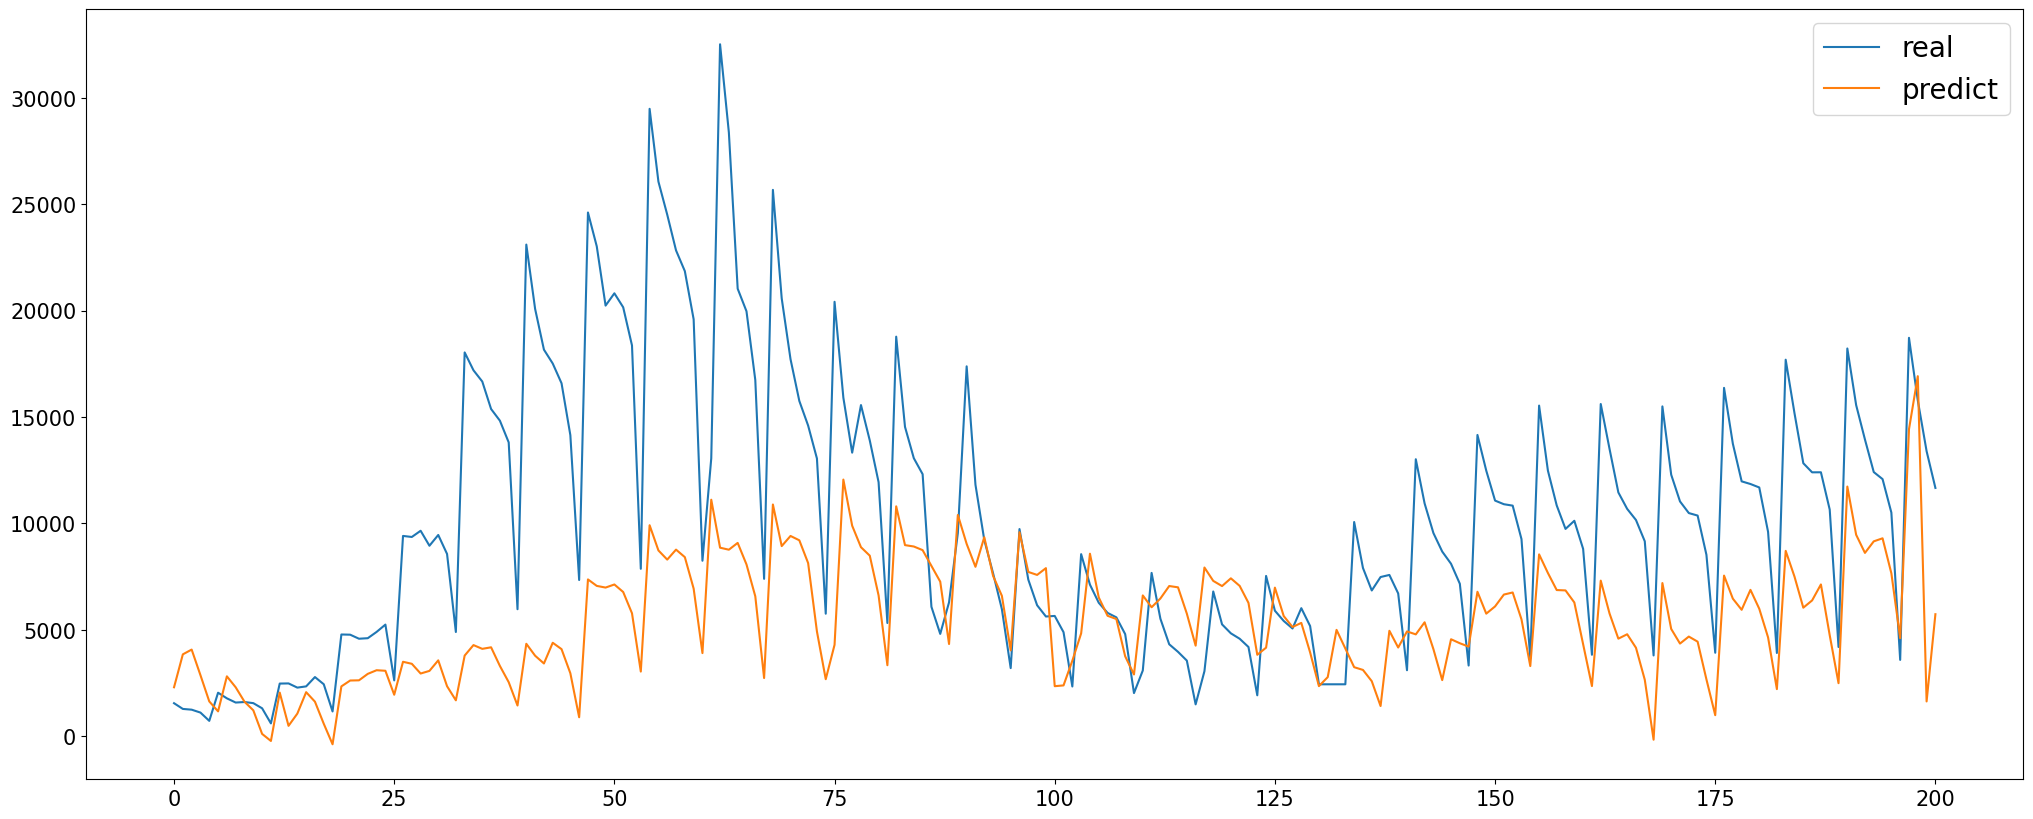

In [15]:
plt.rc('font', size=15) # font가 지정되어 있다면 한글 출력 가능
plt.figure(figsize=(25,10))
plt.plot(inverse_y, label = 'real')
plt.plot(inverse_x, label = 'predict')
# plt.xlabel('테스트 셋 일자')
# plt.ylabel('확진자 수')
plt.rc('legend', fontsize = 20)
plt.legend()
plt.show()

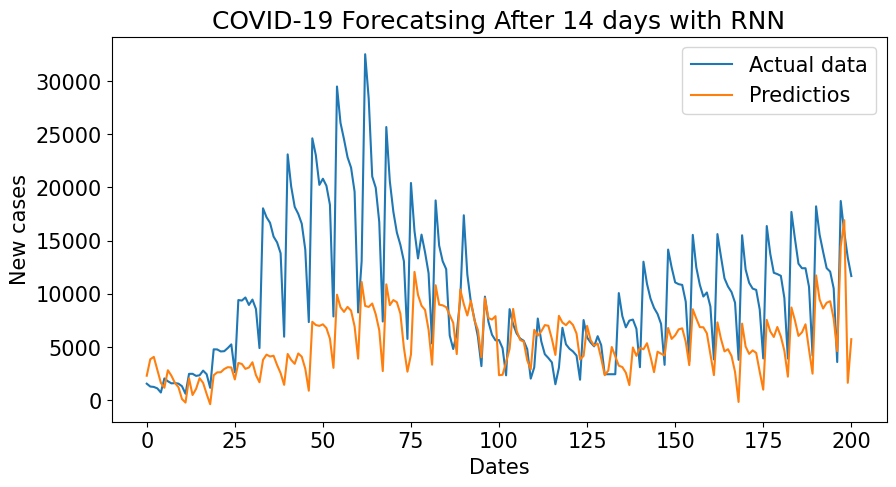

In [16]:
plt.rc('font', size=15)
plt.figure(figsize=(10,5))
plt.plot(inverse_y, label = 'Actual data')
plt.plot(inverse_x, label = 'Predictios')
plt.title('COVID-19 Forecatsing After 14 days with RNN')
plt.xlabel('Dates')
plt.ylabel('New cases')
plt.rc('legend', fontsize = 15)
plt.legend()
plt.show()

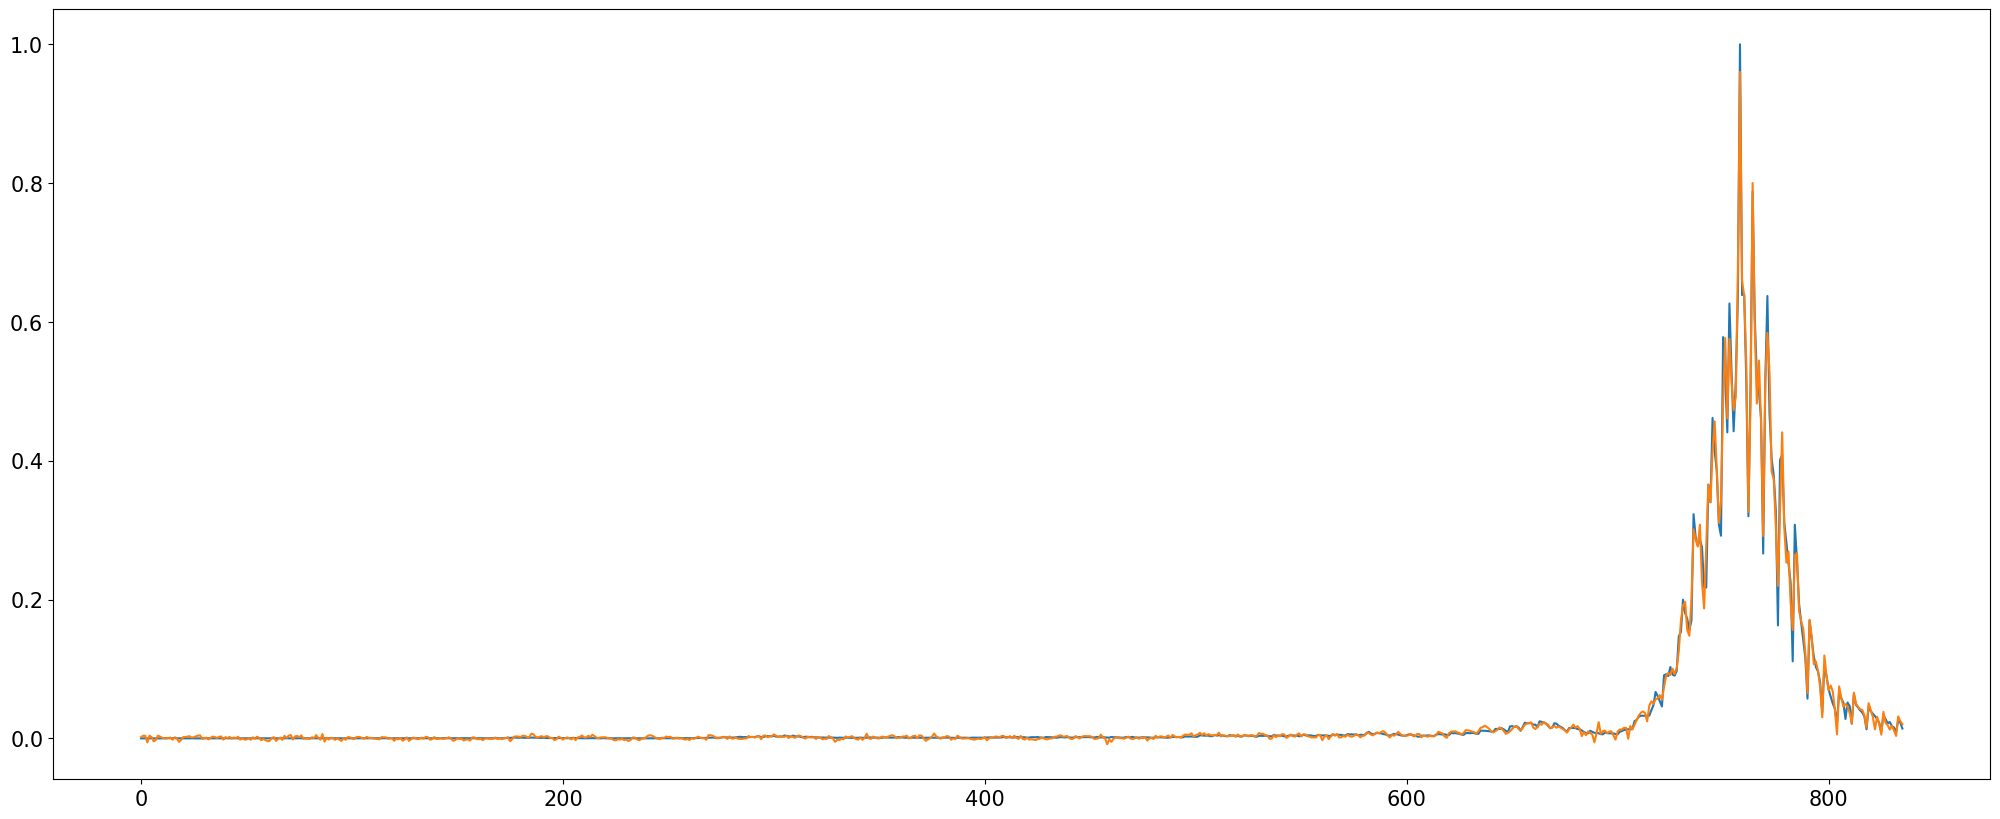

In [17]:
plt.figure(figsize=(25,10))
plt.plot(trainY)
plt.plot(net(trainX_tensor).cpu().data.numpy())
plt.show()

### RMSE 구하기

In [18]:
def rmse(pred, real):
    E = pred-real
    SE = []
    for i in E:
        SE.append(i**2)
    MSE = sum(SE)/len(SE)
    RMSE = MSE**0.5
    return RMSE


print(f'RMSE : {rmse(inverse_x.flatten(), inverse_y.flatten())}')

RMSE : 7104.97370983326
